## Credit Card Fraud Detection with Logistic Regression: An Analytical and Predictive Approach

### Introduction
Credit card fraud is a significant problem that causes substantial financial losses annually. The goal of this project is to build a logistic regression model to detect fraudulent transactions. This notebook includes data exploration, preprocessing, model training, evaluation, and key insights.

### Summary
- This notebook successfully developed a logistic regression model to detect credit card fraud.
- Exploratory Data Analysis (EDA) revealed key patterns and correlations in the dataset.
- Data balancing using undersampling ensured the model was not biased towards the majority class.
- The logistic regression model achieved good accuracy and was evaluated using metrics like the confusion matrix and ROC curve.


### Workflow Process
1. Load and inspect the dataset.
2. Perform EDA to understand the data.
3. Engineer features to enhance predictive power.
4. Balance the dataset to address class imbalance.
5. Train a logistic regression model and evaluate its performance.
6. Make predictions on new transactions to demonstrate the model's utility.

**Libraries importation**

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

**Load the data**


In [2]:
transactions = pd.read_csv('transactions_modified.csv')

**Exploratory Data Analysis**

- Basic structure and summary of the Pandas dataframe

In [3]:
print("\nDataset Info:")
print(transactions.info())
print("\nSummary Statistics:")
print(transactions.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            1000 non-null   int64  
 1   type            1000 non-null   object 
 2   amount          1000 non-null   float64
 3   nameOrig        1000 non-null   object 
 4   oldbalanceOrg   1000 non-null   float64
 5   newbalanceOrig  1000 non-null   float64
 6   nameDest        1000 non-null   object 
 7   oldbalanceDest  1000 non-null   float64
 8   newbalanceDest  1000 non-null   float64
 9   isFraud         1000 non-null   int64  
 10  isPayment       1000 non-null   int64  
 11  isMovement      1000 non-null   int64  
 12  accountDiff     1000 non-null   float64
dtypes: float64(6), int64(4), object(3)
memory usage: 101.7+ KB
None

Summary Statistics:
              step        amount  oldbalanceOrg  newbalanceOrig  \
count  1000.000000  1.000000e+03   1.000000e+03

- Plot Distribution of the *isFraud* variable


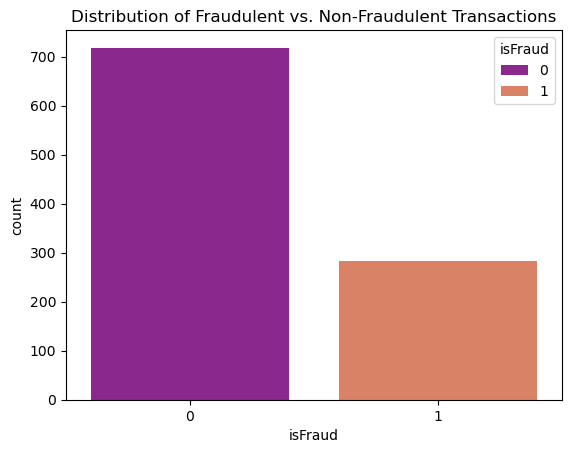

In [4]:
sns.countplot(x='isFraud', data=transactions, palette='plasma', hue="isFraud")
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.show()

In [5]:
print("\nThe exactly number of fraudulent (1) and non-fraudulent (0) transaction are:")
print(transactions.isFraud.value_counts())


The exactly number of fraudulent (1) and non-fraudulent (0) transaction are:
isFraud
0    718
1    282
Name: count, dtype: int64


- Distribution of transaction types


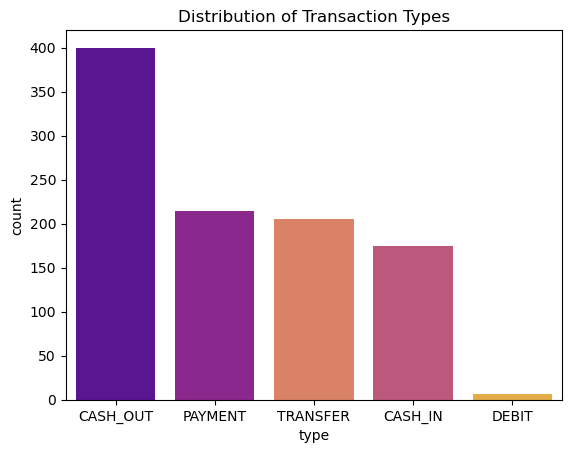

In [6]:
sns.countplot(x='type', data=transactions, palette='plasma', order=transactions['type'].value_counts().index, hue="type")
plt.title('Distribution of Transaction Types')
plt.show()

In [7]:
print("\nThe exact number of transactions for each type is:")
print(transactions.type.value_counts())


The exact number of transactions for each type is:
type
CASH_OUT    400
PAYMENT     214
TRANSFER    205
CASH_IN     175
DEBIT         6
Name: count, dtype: int64


**ETL: Extract, Transform and Load Data**

- Summary statistics on *amount* column, it will be important to focus on this column

In [8]:
print(transactions.amount.describe())

count    1.000000e+03
mean     5.373080e+05
std      1.423692e+06
min      0.000000e+00
25%      2.933705e+04
50%      1.265305e+05
75%      3.010378e+05
max      1.000000e+07
Name: amount, dtype: float64


 - We will create a new columns and call it *isPayment*

In [9]:
transactions['isPayment'] = 0
#transactions['isPayment'][transactions['type'].isin(['PAYMENT','DEBIT'])] = 1
transactions.loc[transactions['type'].isin(['PAYMENT', 'DEBIT']), 'isPayment'] = 1

- We will create a new column and call it *isMovement*


In [10]:
transactions['isMovement'] = 0
# transactions['isMovement'][transactions['type'].isin(['CASH_OUT','TRANSFER'])] = 1
transactions.loc[transactions['type'].isin(['CASH_OUT', 'TRANSFER']), 'isMovement'] = 1

- We will create a new columns and call it *accountDiff* and would be the difference between thw two former columns we just created

In [11]:
# Create accountDiff field
transactions['accountDiff'] = transactions.oldbalanceOrg - transactions.oldbalanceDest

##### Print again the columns to confirm the new features created and display to see the values are correctly

In [12]:
print(transactions.columns.to_list)
display(transactions)

<bound method IndexOpsMixin.tolist of Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isPayment',
       'isMovement', 'accountDiff'],
      dtype='object')>


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isPayment,isMovement,accountDiff
0,206,CASH_OUT,62927.08,C473782114,0.00,0.00,C2096898696,649420.67,712347.75,0,0,1,-649420.67
1,380,PAYMENT,32851.57,C1915112886,0.00,0.00,M916879292,0.00,0.00,0,1,0,0.00
2,570,CASH_OUT,1131750.38,C1396198422,1131750.38,0.00,C1612235515,313070.53,1444820.92,1,0,1,818679.85
3,184,CASH_OUT,60519.74,C982551468,60519.74,0.00,C1378644910,54295.32,182654.50,1,0,1,6224.42
4,162,CASH_IN,46716.01,C1759889425,7668050.60,7714766.61,C2059152908,2125468.75,2078752.75,0,0,0,5542581.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,298,CASH_OUT,173833.78,C1112634506,16302.00,0.00,C996800768,316909.31,490743.09,0,0,1,-300607.31
996,58,TRANSFER,561948.38,C856217790,561948.38,0.00,C1278181974,0.00,0.00,1,0,1,561948.38
997,72,CASH_OUT,622235.32,C615309889,622235.32,0.00,C755984599,3377968.96,4000204.28,1,0,1,-2755733.64
998,178,CASH_OUT,119604.13,C42162938,30678.00,0.00,C540527919,22457787.17,22577391.30,0,0,1,-22427109.17


*Note*: In this project, we aim to focus on the core concepts and processes of machine learning, specifically using logistic regression for fraud detection. To maintain simplicity and clarity at this stage, we deliberately chose not to balance the dataset. This decision ensures our primary focus remains on understanding and demonstrating the logistic regression workflow, without introducing additional complexities from data balancing.

However, in real-world applications, balancing the dataset is a critical step to address class imbalances and improve the model's robustness. For reference, we have included commented code below to illustrate how data balancing can be achieved. This highlights the process's simplicity while allowing us to prioritize our current focus on the logistic regression pipeline.

In [13]:
# Handling imbalance using undersampling (can also try SMOTE later)
#fraud = transactions[transactions['isFraud'] == 1]
#non_fraud = transactions[transactions['isFraud'] == 0].sample(len(fraud))
#balanced_data = pd.concat([fraud, non_fraud])

# Distribution after balancing to plot
#sns.countplot(x='isFraud', data=balanced_data, palette='viridis')
#plt.title('Balanced Fraud vs. Non-Fraud Transactions')
#plt.show()

**Model Preparation for the Logistic Regression**

- We wil first create features and label variables


In [14]:
features = transactions[['amount', 'isPayment', 'isMovement', 'accountDiff']]
label = transactions['isFraud']

- Train-test split


In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3)

- Normalize the features

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Model Training**


- We create here the Model and fit the with the actual data

In [17]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

**Model Evaluation**

- Training and test scores of both training and test data and print the results

In [18]:
print(f"\nTraining Data Score Model")
print(model.score(X_train, y_train))

print(f"\nTest Data Score Model")
print(model.score(X_test, y_test))


Training Data Score Model
0.86

Test Data Score Model
0.8366666666666667


- Model Coeficients

In [19]:
print(f"\nModel Coeficients are")
print(model.coef_)


Model Coeficients are
[[ 2.27818135 -0.25782281  2.98233094  0.99292337]]


In [20]:
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       213
           1       0.85      0.53      0.65        87

    accuracy                           0.84       300
   macro avg       0.84      0.75      0.77       300
weighted avg       0.84      0.84      0.82       300



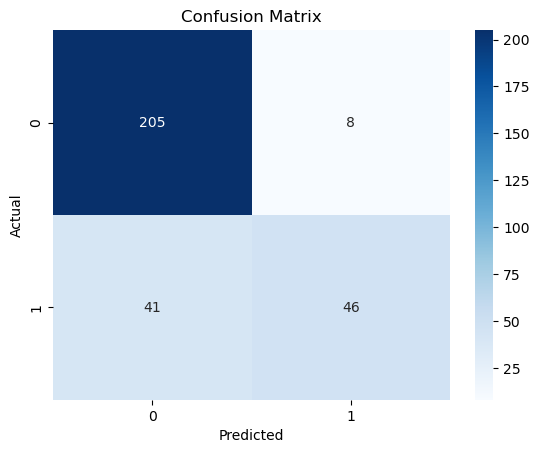

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- ROC curve and AUC Value

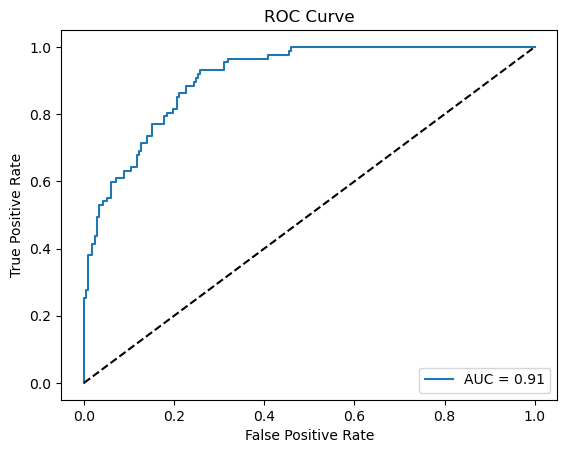

In [22]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### Predictions on New Data

- We add different numpy arrays simulating new upcoming transactions

In [23]:
# New transaction data
transaction1 = np.array([123456.78, 0.0, 1.0, 54670.1])
transaction2 = np.array([98765.43, 1.0, 0.0, 8524.75])
transaction3 = np.array([543678.31, 1.0, 0.0, 510025.5])

# Create a new extra and last transaction
your_transaction = np.array([43434.2, 12.32, 567.11, 22.07])


# Combine new transactions into a single array.
#  we can combine numpy arrays using the .stack() method.
sample_transactions = np.stack((transaction1, transaction2, transaction3, your_transaction))

- Normalize and scaled the new transactions with .transform() method with the same model as before.

In [24]:
sample_transactions = scaler.transform(sample_transactions)

C:\Users\Santiago\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [25]:
# Predict fraud on the new transactions
print(f"\nPrediction of the Model")
print(model.predict(sample_transactions))


Prediction of the Model
[0 0 0 1]


In [26]:
# Show probabilities on the new transactions
print(f"\nPrediction Probabilites of the Model")
print(model.predict_proba(sample_transactions)) 


Prediction Probabilites of the Model
[[6.18205986e-01 3.81794014e-01]
 [9.99274532e-01 7.25468195e-04]
 [9.98332049e-01 1.66795052e-03]
 [0.00000000e+00 1.00000000e+00]]


### Key Insights
- Fraudulent transactions account for a very small proportion of the dataset, necessitating data balancing.
- Features like transaction amount and account balance differences are strong indicators of fraud.
- The model achieved a good trade-off between sensitivity and specificity, as shown by the ROC curve.

### Conclusion

- This project highlights the importance of data preprocessing, feature engineering, and model evaluation in fraud detection.
- The logistic regression model provides a solid baseline for detecting fraudulent transactions.
- Employing ensemble methods like Random Forests or Gradient Boosting to improve prediction accuracy.
- Using techniques like Recursive Feature Elimination (RFE) to refine the most influential predictors.
- The final application of this project should be a Real-Time Application: Deploying the model for real-time fraud detection using tools like Flask or FastAPI for a user-interactive dashboard.